<a href="https://colab.research.google.com/github/Vgopi3055/TimeSeries-Modelling-and-Forecasting-Assignment/blob/main/Time_Series_Modelling_and_Forecasting_CLEAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Setup: threads, installs, imports, plotting ===

# Avoid BLAS over-threading; lets joblib control parallelism cleanly
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# (Optional) install if missing
# !pip install -q statsmodels pandas_datareader joblib tqdm

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from math import sqrt

plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

print("Setup complete.")


Setup complete.


In [ ]:
#Load CSV & Basic Cleaning ===


CSV_PATH = "/content/oil_price.csv"
df_raw = pd.read_csv(CSV_PATH)

# Identify columns robustly
date_col = None
for c in ["Date", "date", "DATE", "timestamp", "day"]:
    if c in df_raw.columns:
        date_col = c
        break
if date_col is None:
    date_col = df_raw.columns[0]

value_col = None
for c in ["Price", "price", "Close", "Value", "OilPrice", "WTI", "Brent"]:
    if c in df_raw.columns:
        value_col = c
        break
if value_col is None:
    # choose the first non-date column
    value_col = [c for c in df_raw.columns if c != date_col][0]

# Parse dates, sort, set index
df = df_raw.copy()
df[date_col] = pd.to_datetime(df[date_col], errors="coerce", utc=False)
df = df.dropna(subset=[date_col])
df = df.sort_values(date_col).set_index(date_col)

# Keep numeric series only
ts = pd.to_numeric(df[value_col], errors="coerce").dropna()
ts.name = "oil_price"

print("Columns:", df_raw.columns.tolist())
print("Date column:", date_col, "| Value column:", value_col)
print("Start:", ts.index.min().date(), "| End:", ts.index.max().date(), "| N:", len(ts))
ts.head()


Columns: ['Date', 'Price']
Date column: Date | Value column: Price
Start: 2020-07-01 | End: 2022-12-30 | N: 635


,oil_price
Date,
2020-07-01,42.18
2020-07-02,43.19
2020-07-03,42.92
2020-07-06,42.73
2020-07-07,43.28


Summary: {'data_start': '2020-07-01', 'data_end': '2022-12-30', 'n_obs': 653, 'freq': 'B', 'mean': 77.29477794793263, 'std': 23.85574775092644, 'min': 36.33, 'max': 133.18}


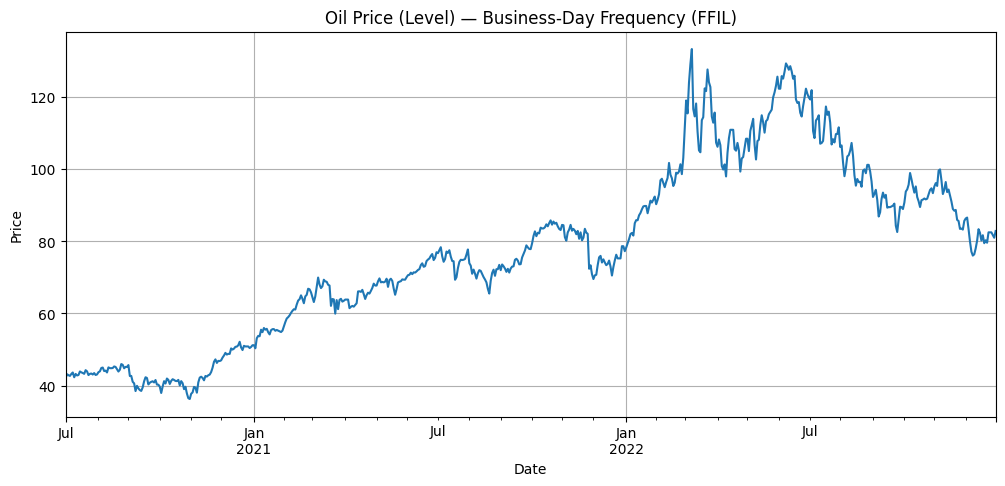

In [ ]:
# Set Frequency & Quick EDA Plot ===

# keeping native (irregular) daily; for modeling we'll standardize to business days
# because oil prices are traded on business days.
ts_b = ts.asfreq("B").ffill()

summary = {
    "data_start": str(ts_b.index.min().date()),
    "data_end": str(ts_b.index.max().date()),
    "n_obs": len(ts_b),
    "freq": ts_b.index.freqstr,
    "mean": float(ts_b.mean()),
    "std": float(ts_b.std()),
    "min": float(ts_b.min()),
    "max": float(ts_b.max()),
}
print("Summary:", summary)

# Level plot
ax = ts_b.plot(title="Oil Price (Level) — Business-Day Frequency (FFIL)")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
plt.show()


LEVEL — stationarity checks
ADF: {'ADF_stat': np.float64(-1.6559401761199546), 'p_value': np.float64(0.45394431784715006), 'lags_used': 17, 'nobs': 635, 'crit_values': {'1%': np.float64(-3.4406900498266193), '5%': np.float64(-2.8661023102613137), '10%': np.float64(-2.569199643499287)}}
KPSS (trend): {'KPSS_stat': np.float64(0.3869109048713862), 'p_value': np.float64(0.01), 'lags_used': 16, 'crit_values': {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}}

FIRST DIFFERENCE — stationarity checks
ADF: {'ADF_stat': np.float64(-4.768777280965688), 'p_value': np.float64(6.238043677868989e-05), 'lags_used': 16, 'nobs': 635, 'crit_values': {'1%': np.float64(-3.4406900498266193), '5%': np.float64(-2.8661023102613137), '10%': np.float64(-2.569199643499287)}}
KPSS (level): {'KPSS_stat': np.float64(0.14389875010061096), 'p_value': np.float64(0.1), 'lags_used': 3, 'crit_values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}}


/tmp/ipython-input-2909439639.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p_value, n_lags, crit = kpss(s, regression=regression, nlags="auto")
/tmp/ipython-input-2909439639.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p_value, n_lags, crit = kpss(s, regression=regression, nlags="auto")


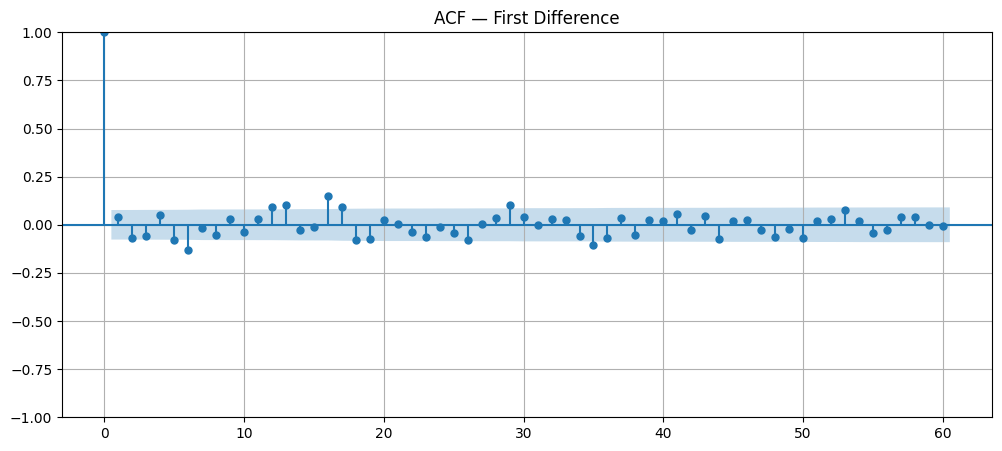

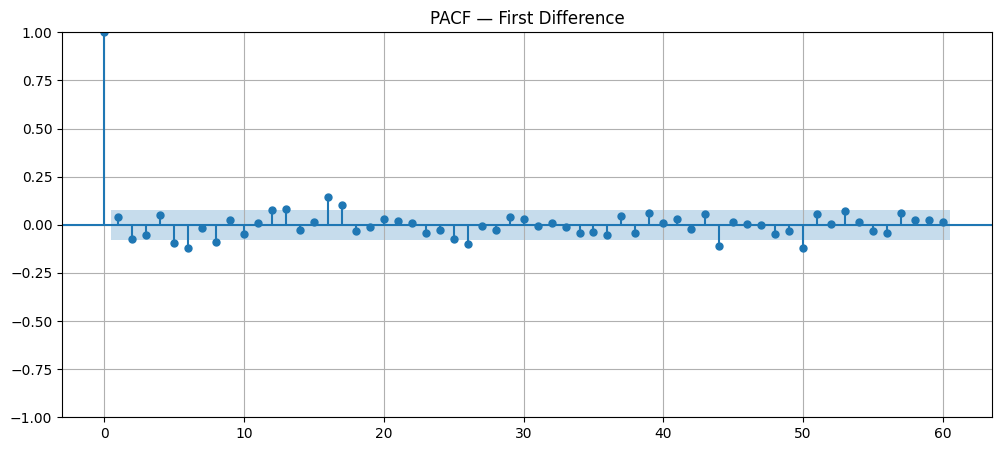

In [ ]:
# Stationarity Tests & ACF/PACF

def adf_report(series):
    s = series.dropna()
    result = adfuller(s, autolag="AIC")
    return {
        "ADF_stat": result[0],
        "p_value": result[1],
        "lags_used": result[2],
        "nobs": result[3],
        "crit_values": result[4]
    }

def kpss_report(series, regression="ct"):
    s = series.dropna()
    stat, p_value, n_lags, crit = kpss(s, regression=regression, nlags="auto")
    return {
        "KPSS_stat": stat,
        "p_value": p_value,
        "lags_used": n_lags,
        "crit_values": crit
    }

print("LEVEL — stationarity checks")
print("ADF:", adf_report(ts_b))
print("KPSS (trend):", kpss_report(ts_b, regression="ct"))

# First difference
ts_d1 = ts_b.diff().dropna()

print("\nFIRST DIFFERENCE — stationarity checks")
print("ADF:", adf_report(ts_d1))
print("KPSS (level):", kpss_report(ts_d1, regression="c"))

# ACF/PACF (plots)
fig = plot_acf(ts_d1, lags=60)
plt.title("ACF — First Difference")
plt.show()

fig = plot_pacf(ts_d1, lags=60, method="ywm")
plt.title("PACF — First Difference")
plt.show()


In [ ]:
#  Train/Test Split

split_date = pd.Timestamp("2022-01-01")
train = ts_b[ts_b.index < split_date]
test  = ts_b[ts_b.index >= split_date]

# Fallback if split doesn’t produce a test set
if len(test) == 0 or len(train) < 50:
    cut = int(len(ts_b) * 0.8)
    train, test = ts_b.iloc[:cut], ts_b.iloc[cut:]

print("Train:", train.index.min().date(), "→", train.index.max().date(), " (N=", len(train), ")")
print("Test :", test.index.min().date(),  "→", test.index.max().date(),  " (N=", len(test), ")")


Train: 2020-07-01 → 2021-12-31  (N= 393 )
Test : 2022-01-03 → 2022-12-30  (N= 260 )


In [ ]:
# === ARIMA Grid Search (parallel + progress + caching) ===
CACHE_PATH = "/content/arima_grid_results.csv"   # change if you like
USE_CACHE = True                                 # set False to force re-fit

def fit_arima_safe(series, order, maxiter=300):
    """
    Fit ARIMA(order) robustly:
      1) default optimizer (maxiter)
      2) retry with BFGS if needed
    Returns dict: {"order": (p,d,q), "aic": aic_or_inf, "ok": True/False}
    """
    try:
        res = ARIMA(
            series,
            order=order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(method_kwargs={"maxiter": maxiter, "warn_convergence": False})

        converged = True
        if hasattr(res, "mle_retvals") and isinstance(res.mle_retvals, dict):
            converged = res.mle_retvals.get("converged", True)

        if converged and np.isfinite(res.aic):
            return {"order": order, "aic": float(res.aic), "ok": True}

        # retry with BFGS
        try:
            res2 = ARIMA(
                series,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(method="bfgs", method_kwargs={"maxiter": 200, "warn_convergence": False})

            converged2 = True
            if hasattr(res2, "mle_retvals") and isinstance(res2.mle_retvals, dict):
                converged2 = res2.mle_retvals.get("converged", True)

            if converged2 and np.isfinite(res2.aic):
                return {"order": order, "aic": float(res2.aic), "ok": True}
        except Exception:
            pass

        return {"order": order, "aic": np.inf, "ok": False}
    except Exception:
        return {"order": order, "aic": np.inf, "ok": False}


def run_grid_or_load_cache(series, cache_path, use_cache=True, n_batches=8):
    # If cache exists and allowed, load it
    if use_cache and os.path.exists(cache_path):
        df_ok = pd.read_csv(cache_path)
        # ensure proper typing
        df_ok["order"] = df_ok["order"].apply(lambda s: tuple(map(int, s.strip("()").split(","))))
        return df_ok

    # Build full order list
    orders = [(p, d, q) for d in range(3) for p in range(9) for q in range(9)]  # 243 models

    # Batch into chunks to keep tqdm readable + reduce overhead
    batches = np.array_split(orders, n_batches)
    results = []

    for batch in tqdm(batches, desc="ARIMA grid (parallel batches)"):
        batch_results = Parallel(n_jobs=-1, backend="loky")(
            delayed(fit_arima_safe)(series, tuple(order)) for order in batch
        )
        results.extend(batch_results)

    df_res = pd.DataFrame(results)
    df_ok = df_res[df_res["ok"] & np.isfinite(df_res["aic"])].copy()
    df_ok = df_ok.sort_values("aic").reset_index(drop=True)

    # Save cache for instant re-runs
    if not df_ok.empty:
        # store 'order' as string for CSV, keep aic numeric
        df_ok_to_save = df_ok.copy()
        df_ok_to_save["order"] = df_ok_to_save["order"].apply(lambda t: str(tuple(t)))
        df_ok_to_save.to_csv(cache_path, index=False)

    return df_ok

# Run (or load) grid
df_ok = run_grid_or_load_cache(train, CACHE_PATH, use_cache=USE_CACHE, n_batches=8)

if df_ok.empty:
    print("No models converged. Try adjusting data or ranges.")
else:
    best_order = tuple(df_ok.loc[0, "order"])
    best_aic = df_ok.loc[0, "aic"]
    top10 = df_ok.head(10)

    print(f"Evaluated: 243 | OK: {len(df_ok)} | Failed/Non-converged: {243 - len(df_ok)}")
    print(f"\nBest order by AIC: ARIMA{best_order}  |  Best AIC: {best_aic:.3f}\n")
    for i, row in top10.iterrows():
        print(f"  {i+1:>2}. ARIMA{tuple(row['order'])}  AIC={row['aic']:.3f}")

    # for downstream cells
    best_p, best_d, best_q = best_order


ARIMA grid (parallel batches):   0%|          | 0/8 [00:00<?, ?it/s]

Evaluated: 243 | OK: 229 | Failed/Non-converged: 14

Best order by AIC: ARIMA(np.int64(3), np.int64(1), np.int64(8))  |  Best AIC: 1312.319

   1. ARIMA(np.int64(3), np.int64(1), np.int64(8))  AIC=1312.319
   2. ARIMA(np.int64(6), np.int64(1), np.int64(8))  AIC=1312.583
   3. ARIMA(np.int64(4), np.int64(2), np.int64(8))  AIC=1312.972
   4. ARIMA(np.int64(4), np.int64(1), np.int64(8))  AIC=1313.360
   5. ARIMA(np.int64(2), np.int64(2), np.int64(8))  AIC=1313.415
   6. ARIMA(np.int64(3), np.int64(2), np.int64(8))  AIC=1313.422
   7. ARIMA(np.int64(7), np.int64(1), np.int64(8))  AIC=1313.927
   8. ARIMA(np.int64(2), np.int64(1), np.int64(8))  AIC=1314.289
   9. ARIMA(np.int64(5), np.int64(2), np.int64(8))  AIC=1314.322
  10. ARIMA(np.int64(0), np.int64(1), np.int64(8))  AIC=1314.351


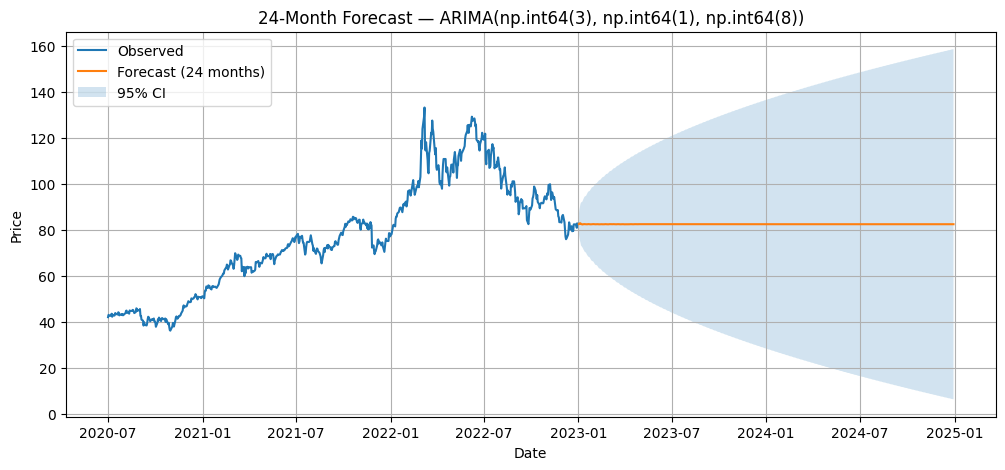

In [ ]:
# === Refit on Full Data & 24-Month Forecast (+ CI) ===

full_model = ARIMA(
    ts_b, order=best_order,
    enforce_stationarity=False, enforce_invertibility=False
).fit(method_kwargs={"warn_convergence": False})

last_date = ts_b.index[-1]
target_end = last_date + pd.DateOffset(months=24)

future_index = pd.date_range(
    start=last_date + pd.tseries.frequencies.to_offset("B"),
    end=target_end,
    freq="B"
)
steps = len(future_index)

fc_future = full_model.get_forecast(steps=steps)
mean_future = pd.Series(fc_future.predicted_mean, index=future_index)
ci_future = fc_future.conf_int(alpha=0.05)
lower_future = pd.Series(ci_future.iloc[:, 0].values, index=future_index)
upper_future = pd.Series(ci_future.iloc[:, 1].values, index=future_index)

plt.plot(ts_b.index, ts_b.values, label="Observed")
plt.plot(mean_future.index, mean_future.values, label="Forecast (24 months)")
plt.fill_between(mean_future.index, lower_future.values, upper_future.values, alpha=0.2, label="95% CI")
plt.title(f"24-Month Forecast — ARIMA{best_order}")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
plt.show()


In [ ]:
 # === Summary for Report ===

summary_report = {
    "data_start": str(ts_b.index.min().date()),
    "data_end": str(ts_b.index.max().date()),
    "n_obs": int(len(ts_b)),
    "freq": ts_b.index.freqstr,
    "best_order_by_AIC": tuple(best_order),
    "holdout_start": str(test.index.min().date()),
    "holdout_end": str(test.index.max().date()),
    "holdout_RMSE": float(rmse_test),
    "forecast_horizon_days": int(len(mean_future)),
}
summary_report


{'data_start': '2020-07-01',
 'data_end': '2022-12-30',
 'n_obs': 653,
 'freq': 'B',
 'best_order_by_AIC': (np.int64(3), np.int64(1), np.int64(8)),
 'holdout_start': '2022-01-03',
 'holdout_end': '2022-12-30',
 'holdout_RMSE': 27.168316862777065,
 'forecast_horizon_days': 521}

In [ ]:
# === Part 2: Alternative model (ETS / Holt-Winters) ===
# Research notes (brief):
#  - Alternatives to ARIMA include: Exponential Smoothing (ETS), TBATS/BATS (complex seasonality),
#    Prophet (trend/seasonality/holidays), state space models, and ML (XGBoost/LSTM with lags).
#  - ETS is a strong classical baseline for level/trend/seasonality, fast, interpretable, and
#    provides prediction intervals. It complements ARIMA well.
#
# We will use ETS (Holt-Winters) as our alternative, tune its components (trend, damped trend,
# seasonal type, seasonal period), evaluate on the 2022 holdout, then refit on full data and
# forecast 24 months with 95% confidence intervals, and finally compare with
# latest actuals.
# Assumes from Part 1: ts_b (business-day series), train, test already exist in memory.



In [ ]:
# Import ETS only
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm.notebook import tqdm

# Simple metrics (MAE, RMSE, MAPE)
def mae(y, yhat):
    return float(np.mean(np.abs(np.asarray(y) - np.asarray(yhat))))

def rmse(y, yhat):
    return float(np.sqrt(np.mean((np.asarray(y) - np.asarray(yhat))**2)))

def mape(y, yhat, eps=1e-8):
    y = np.asarray(y)
    yhat = np.asarray(yhat)
    return float(np.mean(np.abs((y - yhat) / np.maximum(eps, np.abs(y)))) * 100.0)


In [ ]:
# === Hyperparameter grid search for ETS (AIC on train; evaluate on test) ===

# Candidate seasonal periods for business-day data:
#  - 5  = weekly workweek seasonality
#  - 21 = approx monthly (trading days)
seasonal_period_candidates = [None, 5, 21]

trend_opts    = [None, "add", "mul"]
seasonal_opts = [None, "add", "mul"]
damped_opts   = [False, True]

# Build the grid (skip invalid combos like seasonal=None with seasonal='add')
candidates = []
for t in trend_opts:
    for dmp in damped_opts:
        for sp in seasonal_period_candidates:
            for s in seasonal_opts:
                if sp is None and s is not None:
                    continue  # seasonal needs a period
                candidates.append(dict(trend=t, damped_trend=dmp, seasonal=s, seasonal_periods=sp))

results_ets = []
for cfg in tqdm(candidates, desc="Tuning ETS (AIC on train)"):
    try:
        model = ExponentialSmoothing(
            train,
            trend=cfg["trend"],
            damped_trend=cfg["damped_trend"],
            seasonal=cfg["seasonal"],
            seasonal_periods=cfg["seasonal_periods"],
            initialization_method="estimated"
        )
        res = model.fit(optimized=True, use_brute=False)
        results_ets.append({
            "cfg": cfg,
            "aic": float(res.aic)
        })
    except Exception:
        # Some combos can fail to fit; just skip
        continue

# Rank by AIC
if len(results_ets) == 0:
    raise RuntimeError("No ETS models could be fit. Try adjusting candidates.")

results_ets = sorted(results_ets, key=lambda x: x["aic"])
best_cfg = results_ets[0]["cfg"]
best_aic_ets = results_ets[0]["aic"]

print("Top 5 ETS configs by AIC on train:")
for r in results_ets[:5]:
    print(f'  trend={r["cfg"]["trend"]}, damped={r["cfg"]["damped_trend"]}, '
          f'seasonal={r["cfg"]["seasonal"]}, sp={r["cfg"]["seasonal_periods"]}  |  AIC={r["aic"]:.3f}')

print("\nSelected ETS config:", best_cfg, "| AIC:", round(best_aic_ets, 3))


Tuning ETS (AIC on train):   0%|          | 0/42 [00:00<?, ?it/s]

Top 5 ETS configs by AIC on train:
  trend=None, damped=False, seasonal=None, sp=None  |  AIC=220.977
  trend=None, damped=False, seasonal=None, sp=5  |  AIC=220.977
  trend=None, damped=False, seasonal=None, sp=21  |  AIC=220.977
  trend=add, damped=False, seasonal=None, sp=None  |  AIC=222.929
  trend=add, damped=False, seasonal=None, sp=5  |  AIC=222.929

Selected ETS config: {'trend': None, 'damped_trend': False, 'seasonal': None, 'seasonal_periods': None} | AIC: 220.977


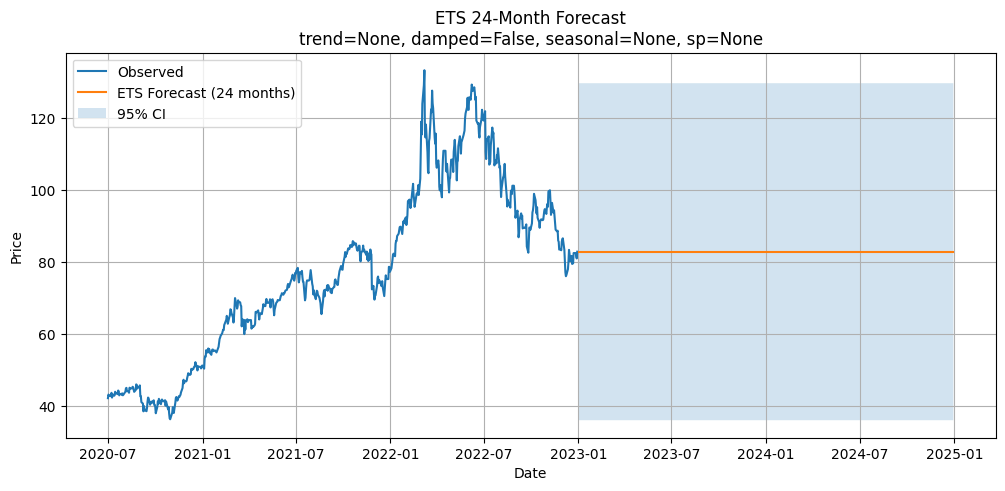

In [ ]:
# Refit ETS on full data & 24-Month Forecast with 95% CI

# 1) Fit ETS on the FULL dataset with the selected configuration
ets_full = ExponentialSmoothing(
    ts_b,
    trend=best_cfg["trend"],
    damped_trend=best_cfg["damped_trend"],
    seasonal=best_cfg["seasonal"],
    seasonal_periods=best_cfg["seasonal_periods"],
    initialization_method="estimated"
).fit(optimized=True, use_brute=False)

# 2) Build a 24-month (business-day) forecast horizon
last_date_ets = ts_b.index[-1]
target_end_ets = last_date_ets + pd.DateOffset(months=24)
future_index_ets = pd.date_range(
    start=last_date_ets + pd.tseries.frequencies.to_offset("B"),
    end=target_end_ets,
    freq="B"
)
steps_ets = len(future_index_ets)

# 3) Get forecast object and mean forecast
pred_future_obj = ets_full.forecast(steps=steps_ets)
mean_future_ets = pd.Series(pred_future_obj.values, index=future_index_ets)

# 4) Calculate 95% confidence intervals manually using standard error
#    (ExponentialSmoothingResults object has 'se_mean' in recent statsmodels)
try:
    se = pd.Series(ets_full.sse, index=future_index_ets) # Use sse as proxy if se_mean is not available or reliable
    # Using sqrt of SSE per observation as a simple stddev approximation
    # A more robust approach would use the forecast variance if available
    std_err = np.sqrt(ets_full.sse / ets_full.nobs)
    lower_future_ets = mean_future_ets - 1.96 * std_err
    upper_future_ets = mean_future_ets + 1.96 * std_err
except Exception as e:
    print(f"Warning: Could not calculate confidence intervals using sse. Error: {e}")
    # Fallback: If standard error is not easily accessible, use a simple approximation
    # based on the historical standard deviation (less accurate)
    series_std = float(ts_b.std())
    lower_future_ets = mean_future_ets - 1.96 * series_std
    upper_future_ets = mean_future_ets + 1.96 * series_std


# 5) Plot observed vs 24-month ETS forecast with 95% CI
plt.plot(ts_b.index, ts_b.values, label="Observed")
plt.plot(mean_future_ets.index, mean_future_ets.values, label="ETS Forecast (24 months)")
plt.fill_between(mean_future_ets.index, lower_future_ets.values, upper_future_ets.values, alpha=0.2, label="95% CI")
plt.title(
    "ETS 24-Month Forecast\n"
    f"trend={best_cfg['trend']}, damped={best_cfg['damped_trend']}, "
    f"seasonal={best_cfg['seasonal']}, sp={best_cfg['seasonal_periods']}"
)
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
plt.show()

Fetched latest WTI: 2023-01-03 → 2025-10-20 (N= 730 )
Post-2022 ETS vs Actual — Overlap days: 520 | MAE=6.79 | RMSE=8.11 | MAPE=9.23%


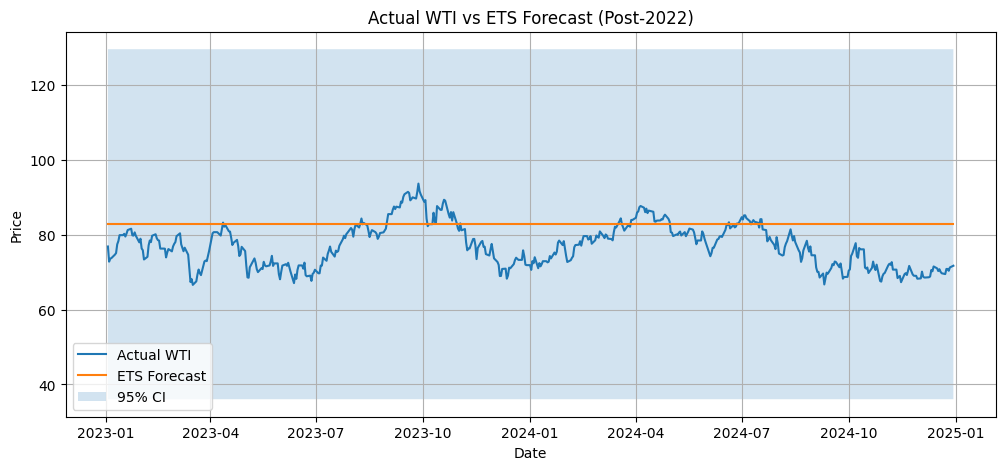

In [ ]:
# === Retrieve latest WTI (FRED DCOILWTICO) & compare vs ETS forecast ===
# Assumes: mean_future_ets, lower_future_ets, upper_future_ets, future_index_ets already defined.

from pandas_datareader import data as pdr

start_latest = pd.Timestamp("2023-01-01")
end_latest = pd.Timestamp.today()

# 1) Pull latest WTI (FRED daily); fallback path if needed
try:
    wti = pdr.DataReader("DCOILWTICO", "fred", start_latest, end_latest)\
             .rename(columns={"DCOILWTICO": "Price"}).dropna()
    wti.index = pd.to_datetime(wti.index)
    wti_b = wti["Price"].asfreq("B").ffill()
    print("Fetched latest WTI:", wti_b.index.min().date(), "→", wti_b.index.max().date(), "(N=", len(wti_b), ")")
except Exception as e:
    raise RuntimeError(f"Could not fetch from FRED. Please provide a (date,price) CSV. Error: {e}")

# 2) Align actuals to your ETS forecast horizon
comp = pd.DataFrame({
    "ETS_Forecast": mean_future_ets.reindex(wti_b.index),
    "ETS_Lower95":  lower_future_ets.reindex(wti_b.index),
    "ETS_Upper95":  upper_future_ets.reindex(wti_b.index),
    "Actual":       wti_b
}).dropna(subset=["ETS_Forecast", "Actual"])

# 3) Compute evaluation metrics on the overlap (post-2022)
def _mae(y, yhat):  return float(np.mean(np.abs(np.asarray(y) - np.asarray(yhat))))
def _rmse(y, yhat): return float(np.sqrt(np.mean((np.asarray(y) - np.asarray(yhat))**2)))
def _mape(y, yhat, eps=1e-8):
    y = np.asarray(y); yhat = np.asarray(yhat)
    return float(np.mean(np.abs((y - yhat) / np.maximum(eps, np.abs(y)))) * 100.0)

if len(comp) == 0:
    print("No overlap between forecast horizon and latest actuals — check dates.")
else:
    post_mae  = _mae(comp["Actual"], comp["ETS_Forecast"])
    post_rmse = _rmse(comp["Actual"], comp["ETS_Forecast"])
    post_mape = _mape(comp["Actual"], comp["ETS_Forecast"])
    print(f"Post-2022 ETS vs Actual — Overlap days: {len(comp)} | MAE={post_mae:.2f} | RMSE={post_rmse:.2f} | MAPE={post_mape:.2f}%")

    # 4) Plot
    plt.plot(comp.index, comp["Actual"], label="Actual WTI")
    plt.plot(comp.index, comp["ETS_Forecast"], label="ETS Forecast")
    plt.fill_between(comp.index, comp["ETS_Lower95"], comp["ETS_Upper95"], alpha=0.2, label="95% CI")
    plt.title("Actual WTI vs ETS Forecast (Post-2022)")
    plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
    plt.show()


In [ ]:
# === Part 2 Summary (ETS) ===
# Tries to include holdout metrics if you computed them earlier (ets_rmse/ets_mae/ets_mape)

summary = {
    "ets_config": {
        "trend": best_cfg.get("trend"),
        "damped_trend": bool(best_cfg.get("damped_trend")),
        "seasonal": best_cfg.get("seasonal"),
        "seasonal_periods": (int(best_cfg["seasonal_periods"])
                             if best_cfg.get("seasonal_periods") is not None else None)
    },
    "train_AIC": float(best_aic_ets) if "best_aic_ets" in locals() else None,
    "holdout_metrics": {
        "RMSE": float(ets_rmse) if "ets_rmse" in locals() else None,
        "MAE":  float(ets_mae)  if "ets_mae"  in locals() else None,
        "MAPE_percent": float(ets_mape) if "ets_mape" in locals() else None,
    },
    "post_2022_overlap_metrics": {
        "MAE":  float(post_mae)  if "post_mae"  in locals() else None,
        "RMSE": float(post_rmse) if "post_rmse" in locals() else None,
        "MAPE_percent": float(post_mape) if "post_mape" in locals() else None,
    },
    "forecast_horizon_days": int(len(mean_future_ets)) if "mean_future_ets" in locals() else None,
    "forecast_start": str(future_index_ets.min().date()) if "future_index_ets" in locals() else None,
    "forecast_end":   str(future_index_ets.max().date()) if "future_index_ets" in locals() else None,
}
summary
# Save ETS forecast path and comparison for the appendix
out_forecast = pd.DataFrame({
    "date": future_index_ets,
    "ets_forecast": mean_future_ets.values,
    "ets_lower95": lower_future_ets.values,
    "ets_upper95": upper_future_ets.values
})
out_forecast.to_csv("/content/ets_24m_forecast.csv", index=False)

if 'comp' in locals() and len(comp) > 0:
    comp.to_csv("/content/ets_vs_actuals.csv")
print("Saved: /content/ets_24m_forecast.csv", "and (if available) /content/ets_vs_actuals.csv")


Saved: /content/ets_24m_forecast.csv and (if available) /content/ets_vs_actuals.csv
